# Room Occupancy Estimation

<a>https://archive.ics.uci.edu/dataset/864/room%2Boccupancy%2Bestimation</a>

In [66]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import joblib
# ==============================================================================


# Métricas y validaciones
# ==============================================================================
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
# ==============================================================================


# Clasificación
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# ==============================================================================


# Visualización de datos
# ==============================================================================
import seaborn as sn
from sklearn import tree
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Data Exploration

In [38]:
df = pd.read_csv('/content/Occupancy_Estimation.csv')
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


In [39]:
df['Room_Occupancy_Count'].value_counts()

0    8228
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64

In [40]:
df_by_occupancy = df['Room_Occupancy_Count'].value_counts()

precision_fig = go.Figure()
precision_fig.add_trace(go.Bar(x = list(df_by_occupancy.keys()), y = (df_by_occupancy.values / df.shape[0]) * 100, name='Train'))

precision_fig.update_layout(
    width = 1500,
    title={
        'text': 'Percentage of data for each class',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="People in the room",
    yaxis_title="%",
)

precision_fig.show()

In [41]:
df.shape

(10129, 19)

In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.940000,25.190000,25.38,25.63,26.380000
S2_Temp,10129.0,25.546059,0.586325,24.750000,25.190000,25.38,25.63,29.000000
S3_Temp,10129.0,25.056621,0.427283,24.440000,24.690000,24.94,25.38,26.190000
S4_Temp,10129.0,25.754125,0.356434,24.940000,25.440000,25.75,26.00,26.560000
S1_Light,10129.0,25.445059,51.011264,0.000000,0.000000,0.00,12.00,165.000000
S2_Light,10129.0,26.016290,67.304170,0.000000,0.000000,0.00,14.00,258.000000
S3_Light,10129.0,34.248494,58.400744,0.000000,0.000000,0.00,50.00,280.000000
S4_Light,10129.0,13.220259,19.602219,0.000000,0.000000,0.00,22.00,74.000000
S1_Sound,10129.0,0.168178,0.316709,0.060000,0.070000,0.08,0.08,3.880000
S2_Sound,10129.0,0.120066,0.266503,0.040000,0.050000,0.05,0.06,3.440000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [44]:
X = df.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])
#X = X.iloc[:, 0:-1]
X

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0
10125,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0
10126,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0
10127,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0


In [45]:
y = df['Room_Occupancy_Count']
y

0        1
1        1
2        1
3        1
4        1
        ..
10124    0
10125    0
10126    0
10127    0
10128    0
Name: Room_Occupancy_Count, Length: 10129, dtype: int64

## Classification

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
train_scores = []
test_scores = []
n_forests = range(1, 50, 1)

for n_forest in n_forests:
    model = RandomForestClassifier(n_estimators=n_forest, n_jobs=-1)
    model.fit(X_train, y_train)

    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(n_forests), y = train_scores,
                    line=dict(color='peru', width=3),
                    name='Train'))
fig.add_trace(go.Scatter(x = list(n_forests), y = test_scores,
                    line=dict(color='indigo', width=3),
                    name='Test'))
fig.update_layout(
    width = 1000,
    title={
        'text': "RF accuracy for different number of estimators",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Estimators",
    yaxis_title="%",
)

fig.show()

In [49]:
train_scores = []
test_scores = []
max_depths = range(1, 33, 1)

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=10, n_jobs=-1)
    model.fit(X_train, y_train)

    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(max_depths), y = train_scores,
                    line=dict(color='peru', width=3),
                    name='Entrenamiento'))
fig.add_trace(go.Scatter(x = list(max_depths), y = test_scores,
                    line=dict(color='indigo', width=3),
                    name='Prueba'))
fig.update_layout(
    width = 1000,
    title={
        'text': "RF accuracy for different values of depth",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Depth",
    yaxis_title="%",
)

fig.show()

In [51]:
rf_model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0, n_jobs=-1)

In [52]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1, random_state=0)

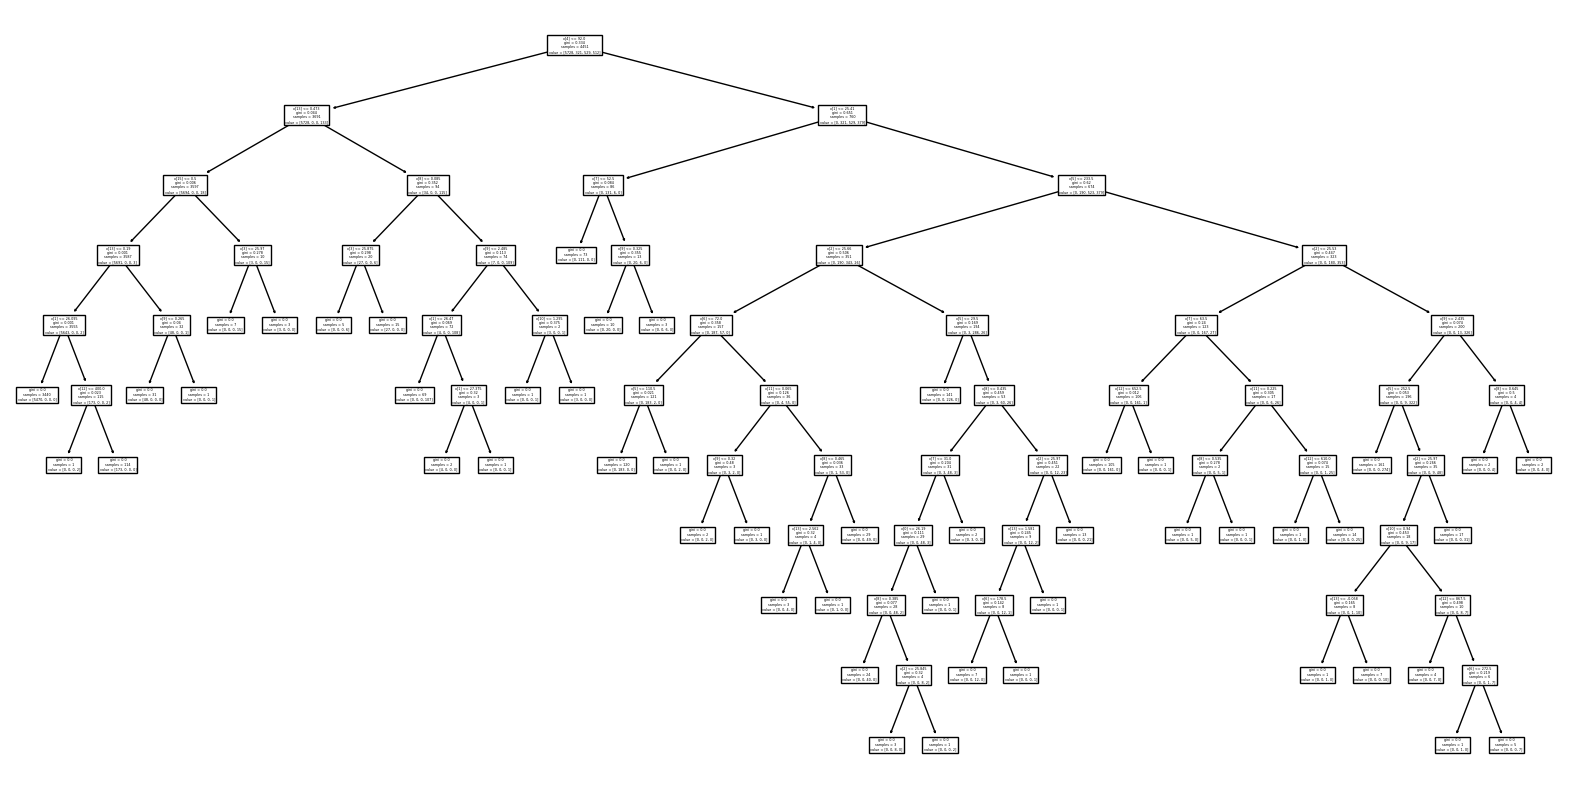

In [53]:
plt.figure(figsize=(20,10))
tree.plot_tree(rf_model.estimators_[0])
plt.show()

In [54]:
rf_model.score(X_test, y_test)

0.9970384995064165

In [55]:
scores = cross_val_score(rf_model, X, y, cv=5)
scores

array([0.97680158, 0.97680158, 0.99506417, 0.97384008, 0.93876543])

In [56]:
prec_train, recall_train, _, _ = precision_recall_fscore_support(y_train, rf_model.predict(X_train), average=None)
prec_test, recall_test, _, _ = precision_recall_fscore_support(y_test, rf_model.predict(X_test), average=None)

In [57]:
precision_fig = go.Figure()
precision_fig.add_trace(go.Bar(x = list(df_by_occupancy.keys()), y = prec_train, name='Train'))
precision_fig.add_trace(go.Bar(x = list(df_by_occupancy.keys()), y = prec_test, name='Test'))

precision_fig.update_layout(
    width = 1500,
    title={
        'text': 'Accuracy for each class',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Class",
    yaxis_title="Accuracy",
)

precision_fig.show()

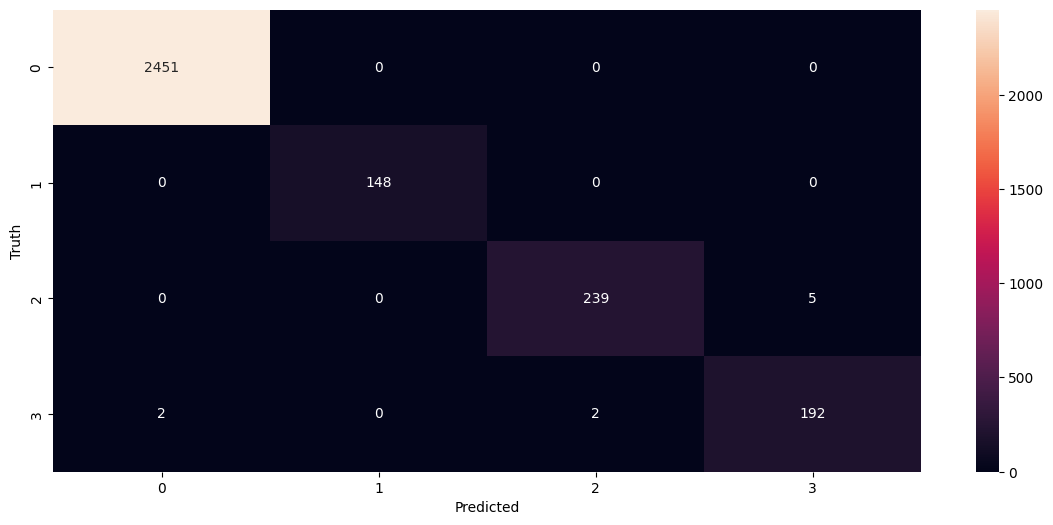

In [68]:
cm = confusion_matrix(y_test, rf_model.predict(X_test))

plt.figure(figsize=(14, 6))
sn.heatmap(cm, annot=True, fmt='g')
#plt.xlim(-0.1, 2)
#plt.ylim(2, -0.1)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [69]:
joblib.dump(rf_model, "./rf_model.joblib")

['./rf_model.joblib']

In [70]:
#loaded_rf = joblib.load("./rf_model.joblib")

### SVM classification

In [64]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.9930898321816387

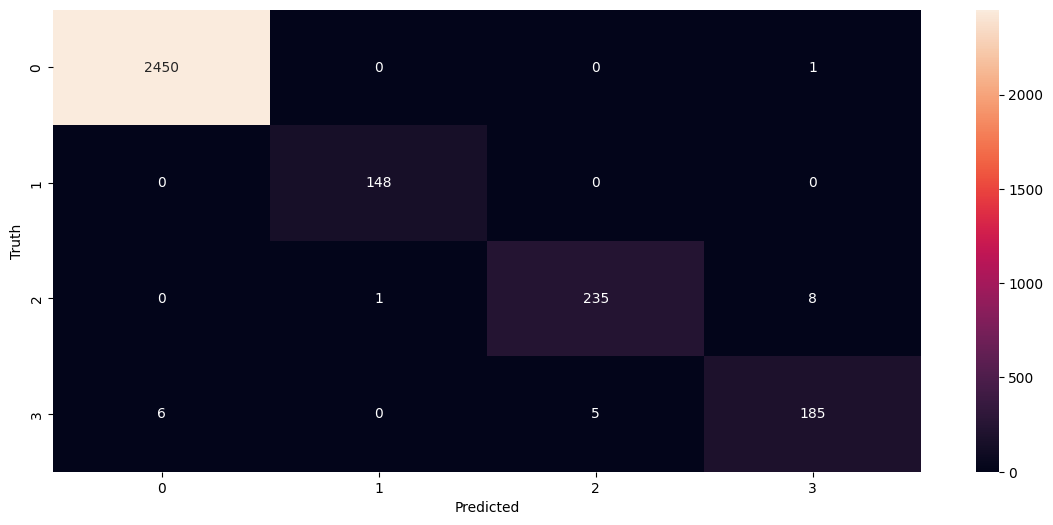

In [65]:
cm2 = confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(14, 6))
sn.heatmap(cm2, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()